In [1]:
import pandas as pd
import numpy as np
import gc
from pathlib import Path
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

data_dir = str(Path.cwd().parent / "dataset" / "processed" / "processed_sales_data.csv")

In [2]:
def reduce_memory_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe is: {start_mem:.2f} MB")

    for col in df.columns:
        if df[col].dtype == "float64":
            df[col] = pd.to_numeric(df[col], downcast="float")
        elif df[col].dtype == "int64":
            df[col] = pd.to_numeric(df[col], downcast="integer")
        elif df[col].dtype == "object":
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage after optimization is: {end_mem:.2f} MB")

    return df

In [ ]:
df = pd.read_csv(data_dir)
df = reduce_memory_usage(df)
gc.collect()
# df.drop(columns=["week_of_year", "year", "Unnamed: 0"], inplace=True)
# df.drop(columns=["Unnamed: 0"], inplace=True)
df["quarter"] = df["week_of_year"].apply(lambda x: (x - 1) // 13 + 1)

df.dropna(inplace=True)

Memory usage of dataframe is: 1112.51 MB
Memory usage after optimization is: 461.78 MB


<class 'pandas.core.frame.DataFrame'>
Index: 4551467 entries, 56 to 5832736
Data columns (total 33 columns):
 #   Column                Dtype   
---  ------                -----   
 0   Unnamed: 0            int32   
 1   item_id               category
 2   dept_id               category
 3   cat_id                category
 4   sales                 int16   
 5   wday                  int8    
 6   month                 int8    
 7   year                  int16   
 8   sell_price            float32 
 9   lag_7                 float32 
 10  lag_14                float32 
 11  lag_28                float32 
 12  rolling_mean_7        float32 
 13  rolling_std_7         float32 
 14  rolling_mean_14       float32 
 15  rolling_std_14        float32 
 16  rolling_mean_28       float32 
 17  rolling_std_28        float32 
 18  rolling_mean_56       float32 
 19  rolling_std_56        float32 
 20  expanding_mean        float32 
 21  price_change_pct      float32 
 22  rolling_price_std_4w  

In [5]:
df.drop(columns=["Unnamed: 0"], inplace=True)
df["log_sales"] = np.log1p(df["sales"])

cat_features = ["item_id", "dept_id", "cat_id"]
# Encode categorical features
for col in cat_features:
    df[col] = df[col].astype("category")

In [8]:
## Prepare features
X = df.drop(columns=["sales", "log_sales"])
Y = df["log_sales"]

# Split train, test, val
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.1, random_state=42)
train_set = lgb.Dataset(X_train, label=Y_train, categorical_feature=cat_features)
valid_set = lgb.Dataset(X_valid, label=Y_valid, categorical_feature=cat_features)

# del X_train, Y_train, X_valid, Y_valid
# gc.collect()

In [10]:
%%time

# Setup training parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.075,
    'num_leaves': 64,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbosity': -1,
}

model = lgb.train(
    params,
    train_set,
    valid_sets=[train_set, valid_set],
    num_boost_round=5000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.517161	valid_1's rmse: 0.52116
[200]	training's rmse: 0.51288	valid_1's rmse: 0.519432
[300]	training's rmse: 0.510781	valid_1's rmse: 0.518687
[400]	training's rmse: 0.509293	valid_1's rmse: 0.518237
[500]	training's rmse: 0.508093	valid_1's rmse: 0.517928
[600]	training's rmse: 0.507087	valid_1's rmse: 0.517697
[700]	training's rmse: 0.506128	valid_1's rmse: 0.51751
[800]	training's rmse: 0.50522	valid_1's rmse: 0.517318
[900]	training's rmse: 0.504377	valid_1's rmse: 0.51712
[1000]	training's rmse: 0.503621	valid_1's rmse: 0.517008
[1100]	training's rmse: 0.502907	valid_1's rmse: 0.516903
[1200]	training's rmse: 0.502185	valid_1's rmse: 0.516769
[1300]	training's rmse: 0.501533	valid_1's rmse: 0.516671
[1400]	training's rmse: 0.500907	valid_1's rmse: 0.516581
[1500]	training's rmse: 0.500256	valid_1's rmse: 0.516479
[1600]	training's rmse: 0.499612	valid_1's rmse: 0.516369
[1700]	training's rmse: 0

In [16]:
def mape(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error (MAPE).
    Ensures zero values in sales data do not cause division by zero errors.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))


RMSE: 3.71
MAPE: 55.21%


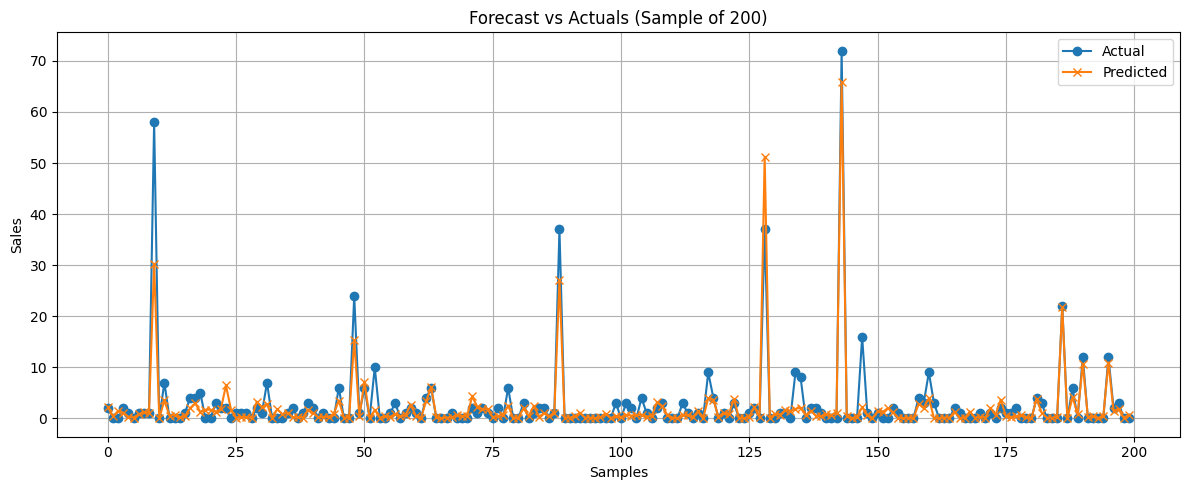

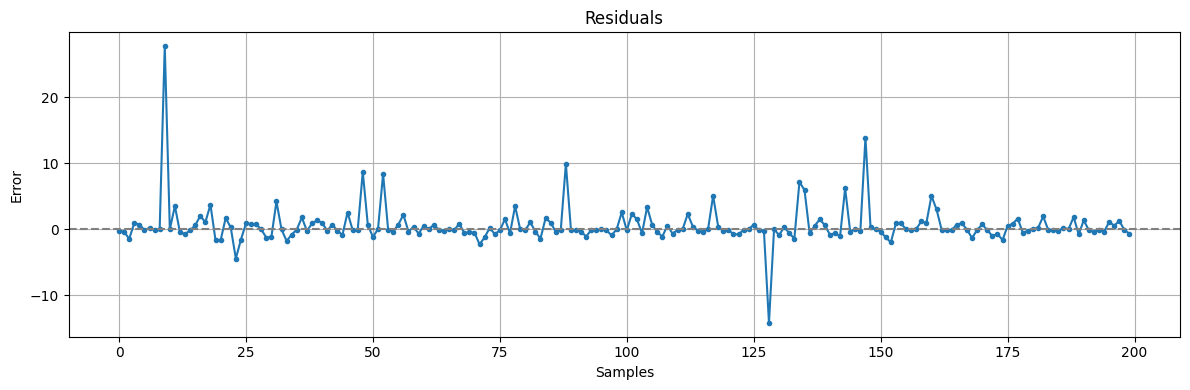

In [ ]:
preds_log = model.predict(X_valid, num_iteration=100)
preds = np.expm1(preds_log)
y_valid = np.expm1(Y_valid)

rmse = np.sqrt(mean_squared_error(y_valid, preds))
mape = mape(y_valid, preds)

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape * 100:.2f}%")

# Sample of 200 predictions
plt.figure(figsize=(12, 5))
plt.plot(y_valid.values[:200], label="Actual", marker="o")
plt.plot(preds[:200], label="Predicted", marker="x")
plt.title("Forecast vs Actuals")
plt.xlabel("Samples")
plt.ylabel("Sales")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

residuals = y_valid.values - preds
plt.figure(figsize=(12, 4))
plt.plot(residuals[:200], label="Residuals", marker=".")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Residuals")
plt.xlabel("Samples")
plt.ylabel("Error")
plt.grid()
plt.tight_layout()
plt.show()

In [19]:
model_dir = str(Path.cwd().parent / "models" / "lgbm_sales_model.pkl")

import joblib
joblib.dump(model, model_dir)

['/home/delen007/qwerty/inventory_forecast/models/lgbm_sales_model.pkl']